# Extra Credit – Avance 4 | FinanceGuard Churn
## Optimización del umbral y matriz de confusión con costos

---

### Objetivo de este notebook

En el **Avance 2** elegimos el **mejor modelo supervisado** (XGBoost optimizado) para predecir churn. Ese modelo devuelve **probabilidades** (por ejemplo: "este cliente tiene 73% de probabilidad de irse").

Para pasar de probabilidad a decisión ("¿lo marcamos como churn o no?") usamos un **umbral (threshold)**. Por defecto suele ser **0.5**: si P(churn) ≥ 0.5 → predecimos "Churn".

**Problema:** El 0.5 no tiene por qué ser lo mejor para el negocio. Si no detectar a un cliente que se va (Falso Negativo) es muy caro, nos conviene **bajar el umbral** (alertar más). Si las campañas de retención son caras (Falsos Positivos), quizá nos convenga **subir el umbral** (alertar menos).

En este Extra Credit vamos a:
1. **Optimizar el umbral** según una métrica de negocio (coste total o F1).
2. **Construir la matriz de confusión con costos** para ver el impacto económico de cada tipo de error (TP, TN, FP, FN).

---

**Requisitos de la homework (4_avance_pi.md):**
- Optimización del threshold según métricas de negocio.
- Matriz de confusión con costos personalizados.

## 1. Setup y librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import xgboost as xgb

np.random.seed(42)
print('✅ Librerías cargadas')

✅ Librerías cargadas


**📝 Explicación:** Usamos las mismas librerías que en los avances anteriores. `xgboost` nos da el modelo ganador; `sklearn.metrics` nos permite calcular métricas y matriz de confusión para distintos umbrales.

## 2. Datos y preprocesamiento

Cargamos el mismo dataset de churn y aplicamos **exactamente el mismo preprocesamiento** que en Avance 1 y 2 (clase_03 y clase_06) para mantener consistencia.

In [2]:
# Ruta al CSV de churn (desde clase_09_series_temporales/notebooks)
path_csv = '../../clase_03_regresion_logistica/data/Churn_Modelling.csv'
df = pd.read_csv(path_csv)

print(f'📊 Dataset: {df.shape[0]:,} filas, {df.shape[1]} columnas')
print(f'   Churn (Exited=1): {(df["Exited"]==1).mean()*100:.1f}%')

# Eliminar columnas no usadas como features
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Encoding (igual que Avance 1)
le_gender = LabelEncoder()
df_model['Gender'] = le_gender.fit_transform(df_model['Gender'])

geography_dummies = pd.get_dummies(df_model['Geography'], prefix='Geography', drop_first=True)
df_model = pd.concat([df_model, geography_dummies], axis=1).drop('Geography', axis=1)

# Target y features
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Split estratificado (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalar (necesario para consistencia con el entrenamiento del Avance 2)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

print(f'✅ Train: {len(X_train):,} | Test: {len(X_test):,}')
print(f'   Features: {list(X.columns)}')

📊 Dataset: 10,000 filas, 14 columnas
   Churn (Exited=1): 20.4%
✅ Train: 8,000 | Test: 2,000
   Features: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']


## 3. Entrenar el mejor modelo supervisado (XGBoost)

Usamos **XGBoost** con los **hiperparámetros óptimos** obtenidos en el Avance 2 (Grid Search), para tener probabilidades de churn en test y poder variar el umbral después.

In [3]:
# Parámetros óptimos del Grid Search (Avance 2 - clase_06)
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 0.8,
}

model = xgb.XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Probabilidades en test (columna 1 = P(Exited=1))
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Predicción con umbral por defecto 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

print('🏆 Modelo XGBoost (mejor supervisado del Avance 2) entrenado')
print(f'   ROC-AUC (test): {roc_auc_score(y_test, y_proba):.4f}')
print(f'   Con umbral 0.5 → Accuracy: {accuracy_score(y_test, y_pred_default):.4f} | F1: {f1_score(y_test, y_pred_default):.4f}')
print(f'   Recall (umbral 0.5): {recall_score(y_test, y_pred_default):.4f} | Precision: {precision_score(y_test, y_pred_default):.4f}')

🏆 Modelo XGBoost (mejor supervisado del Avance 2) entrenado
   ROC-AUC (test): 0.8712
   Con umbral 0.5 → Accuracy: 0.8670 | F1: 0.5920
   Recall (umbral 0.5): 0.4742 | Precision: 0.7878


---

**📚 Recordatorio – Matriz de confusión:**

|                    | Predicho No-Churn | Predicho Churn |
|--------------------|-------------------|----------------|
| **Real No-Churn**  | TN                | FP (falsa alarma) |
| **Real Churn**     | FN (no detectado) | TP             |

- **FN (Falso Negativo):** El cliente se iba y no lo detectamos → perdemos la oportunidad de retenerlo.
- **FP (Falso Positivo):** Lo marcamos como churn y no se iba → gastamos en campaña innecesaria.
- **TP/TN:** Aciertos (retener al que se iba, no molestar al que no).

## 4. Optimización del umbral (threshold)

Vamos a **probar muchos umbrales** (por ejemplo de 0.2 a 0.8) y para cada uno calcular:
- Métricas estándar: Accuracy, F1, Precision, Recall.
- Una **métrica de negocio**: el **coste total** suponiendo costes por FN y FP (TN y TP suelen tener coste 0 o beneficio).

El **umbral óptimo** será el que **minimice el coste total** (o maximice F1, según lo que definamos como objetivo).

In [4]:
# Definición de costes (ejemplo didáctico – ajustar a números reales del negocio)
# Coste de NO detectar un churner: perdemos el cliente (ej. 500 USD)
COST_FN = 500
# Coste de falsa alarma: campaña de retención innecesaria (ej. 50 USD)
COST_FP = 50
# TP y TN: coste 0 (o beneficio; aquí simplificamos a 0)
COST_TP = 0
COST_TN = 0

def cost_from_cm(tn, fp, fn, tp, cost_tn=0, cost_fp=50, cost_fn=500, cost_tp=0):
    """Coste total a partir de conteos de la matriz de confusión."""
    return cost_tn * tn + cost_fp * fp + cost_fn * fn + cost_tp * tp

thresholds = np.arange(0.2, 0.81, 0.02)
results = []

for th in thresholds:
    y_pred_t = (y_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = cost_from_cm(tn, fp, fn, tp, COST_TN, COST_FP, COST_FN, COST_TP)
    results.append({
        'threshold': th,
        'accuracy': accuracy_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t, zero_division=0),
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
        'total_cost': total_cost,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    })

df_results = pd.DataFrame(results)
best_by_cost = df_results.loc[df_results['total_cost'].idxmin()]
best_by_f1 = df_results.loc[df_results['f1'].idxmax()]

print('📌 Costes asumidos (ejemplo):')
print(f'   Coste FN (no detectar churn): {COST_FN} USD')
print(f'   Coste FP (falsa alarma):       {COST_FP} USD')
print(f'\n🎯 Umbral que MINIMIZA coste total: {best_by_cost["threshold"]:.2f}')
print(f'   Coste total (test): {best_by_cost["total_cost"]:,.0f} USD')
print(f'   Recall: {best_by_cost["recall"]:.4f} | Precision: {best_by_cost["precision"]:.4f} | F1: {best_by_cost["f1"]:.4f}')
print(f'\n🎯 Umbral que MAXIMIZA F1: {best_by_f1["threshold"]:.2f}')
print(f'   F1: {best_by_f1["f1"]:.4f} | Coste total: {best_by_f1["total_cost"]:,.0f} USD')

📌 Costes asumidos (ejemplo):
   Coste FN (no detectar churn): 500 USD
   Coste FP (falsa alarma):       50 USD

🎯 Umbral que MINIMIZA coste total: 0.20
   Coste total (test): 64,050 USD
   Recall: 0.7641 | Precision: 0.4921 | F1: 0.5987

🎯 Umbral que MAXIMIZA F1: 0.30
   F1: 0.6444 | Coste total: 76,550 USD


**Interpretación:** Si el coste de no detectar un churner (FN) es mucho mayor que el de una falsa alarma (FP), el umbral óptimo suele **bajar** (más Recall, más alertas). Si las campañas son muy caras (FP alto), el umbral óptimo puede **subir** (menos alertas, menos FPs).

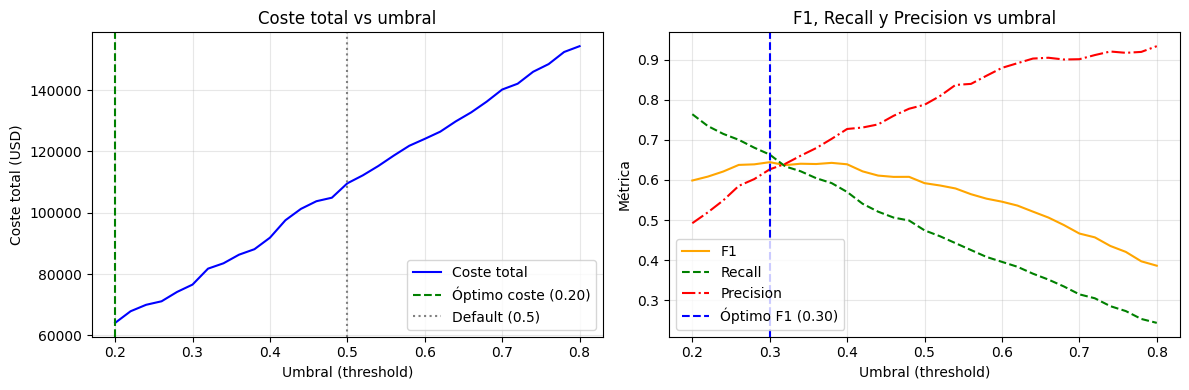

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(df_results['threshold'], df_results['total_cost'], 'b-', label='Coste total')
ax.axvline(best_by_cost['threshold'], color='green', linestyle='--', label=f"Óptimo coste ({best_by_cost['threshold']:.2f})")
ax.axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')
ax.set_xlabel('Umbral (threshold)')
ax.set_ylabel('Coste total (USD)')
ax.set_title('Coste total vs umbral')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(df_results['threshold'], df_results['f1'], 'orange', label='F1')
ax.plot(df_results['threshold'], df_results['recall'], 'g--', label='Recall')
ax.plot(df_results['threshold'], df_results['precision'], 'r-.', label='Precision')
ax.axvline(best_by_f1['threshold'], color='blue', linestyle='--', label=f"Óptimo F1 ({best_by_f1['threshold']:.2f})")
ax.set_xlabel('Umbral (threshold)')
ax.set_ylabel('Métrica')
ax.set_title('F1, Recall y Precision vs umbral')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Matriz de confusión con costos personalizados

Mostramos la **matriz de confusión** para dos umbrales:
1. **Umbral por defecto 0.5** (como referencia).
2. **Umbral óptimo por coste** (el que minimiza el coste total).

En cada celda indicamos el **conteo** y el **coste asociado** (por ejemplo: celda FN → cantidad × coste por FN).

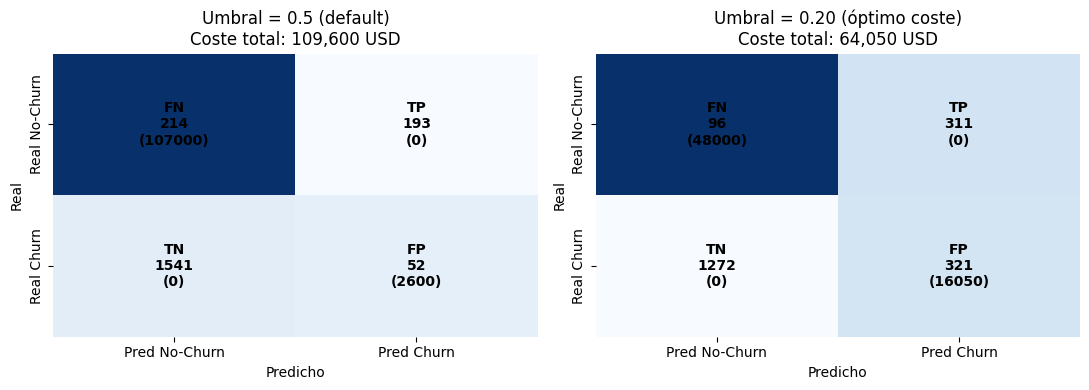

📊 Comparación: Coste con umbral 0.5 = 109,600 USD | Coste con umbral óptimo = 64,050 USD
   Ahorro al usar umbral óptimo: 45,550 USD (41.6%)


In [6]:
def plot_confusion_matrix_with_costs(y_true, y_pred, costs_dict, title, ax):
    """
    Dibuja matriz de confusión con conteos y coste por celda.
    costs_dict: {'TN': 0, 'FP': 50, 'FN': 500, 'TP': 0}
    Usamos heatmap sin annot y luego ax.text() para que todas las celdas muestren el texto.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost_tn = tn * costs_dict['TN']
    cost_fp = fp * costs_dict['FP']
    cost_fn = fn * costs_dict['FN']
    cost_tp = tp * costs_dict['TP']
    total = cost_tn + cost_fp + cost_fn + cost_tp

    # Heatmap solo con valores numéricos (sin anotaciones multilínea)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Pred No-Churn', 'Pred Churn'],
                yticklabels=['Real No-Churn', 'Real Churn'])
    # Añadir texto en cada celda (conteo + coste) con ax.text para que se vean todas las filas
    labels_2d = [
        [f'TN\n{tn}\n({cost_tn:.0f})', f'FP\n{fp}\n({cost_fp:.0f})'],
        [f'FN\n{fn}\n({cost_fn:.0f})', f'TP\n{tp}\n({cost_tp:.0f})']
    ]
    for i in range(2):
        for j in range(2):
            # En heatmap fila 0 está arriba: centro (j+0.5, 1.5-i)
            ax.text(j + 0.5, 1.5 - i, labels_2d[i][j], ha='center', va='center',
                    fontsize=10, color='black', fontweight='bold')
    ax.set_title(f'{title}\nCoste total: {total:,.0f} USD')
    ax.set_ylabel('Real')
    ax.set_xlabel('Predicho')

costs_dict = {'TN': COST_TN, 'FP': COST_FP, 'FN': COST_FN, 'TP': COST_TP}

y_pred_opt = (y_proba >= best_by_cost['threshold']).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
plot_confusion_matrix_with_costs(y_test, y_pred_default, costs_dict, 'Umbral = 0.5 (default)', axes[0])
plot_confusion_matrix_with_costs(y_test, y_pred_opt, costs_dict, f'Umbral = {best_by_cost["threshold"]:.2f} (óptimo coste)', axes[1])
plt.tight_layout()
plt.show()

cost_default = cost_from_cm(*confusion_matrix(y_test, y_pred_default).ravel(), COST_TN, COST_FP, COST_FN, COST_TP)
cost_opt = cost_from_cm(*confusion_matrix(y_test, y_pred_opt).ravel(), COST_TN, COST_FP, COST_FN, COST_TP)
print(f'📊 Comparación: Coste con umbral 0.5 = {cost_default:,.0f} USD | Coste con umbral óptimo = {cost_opt:,.0f} USD')
print(f'   Ahorro al usar umbral óptimo: {cost_default - cost_opt:,.0f} USD ({(1 - cost_opt/cost_default)*100:.1f}%)')

**Resumen:** La matriz con costos permite ver de un vistazo cuánto aporta cada tipo de error al coste total. Ajustar el umbral según los costes reales del negocio puede reducir de forma importante el coste total respecto al umbral por defecto 0.5.

## 6. Conclusión del Extra Credit (data-driven)

**Evidencia de los outputs del notebook:**

- Con **umbral por defecto 0.5**: coste total en test = **109 600 USD**; Recall = 0,47 y Precision = 0,79. El modelo es conservador: detecta menos churners (bajo recall) y muchos no detectados (FN) generan la mayor parte del coste (500 USD × FN).
- El **umbral que minimiza el coste total** (con COST_FN=500, COST_FP=50) es **0,20**. Con ese umbral el coste total en test baja a **64 050 USD**, es decir un **ahorro de 45 550 USD (41,6%)** respecto al umbral 0,5.
- Con umbral 0,20: Recall sube a **0,76** (detectamos más churners) y Precision baja a **0,49** (más falsas alarmas). El trade-off es favorable porque el coste de un FN (500) es muy superior al de un FP (50).
- Si en cambio se prioriza **F1**, el umbral óptimo es **0,30** (F1 ≈ 0,64), con un coste total de **76 550 USD**, mayor que con 0,20; es decir, maximizar F1 no minimiza coste con estos costes de negocio.
- **Matriz de confusión con costos:** Las cuatro celdas (TN, FP, FN, TP) con su conteo y coste muestran de dónde viene el coste total y justifican el umbral elegido (p. ej. reducción de FN al bajar el umbral).

**Recomendaciones:**

- Usar **umbral 0,20** en producción si los costes asumidos (500 USD/FN, 50 USD/FP) son representativos; si no, recalibrar con negocio y repetir el barrido de umbrales.
- Revisar periódicamente cuando cambien costes de campaña o valor del cliente.